In [1]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import BatchNormalization, Lambda, Concatenate, Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
from datetime import datetime
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from AttentionModules import SelfAttention_gl as SelfAttention,CrossAttention_gl as CrossAttention
import sys,os
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
dnf700 = pd.read_json('evaluation_set/deepnofakes/dnf_700/initial.json')
dnf_eval = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V2.json')
dnf_eval.columns = ['authors', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls'] 
with open('evaluation_set/deepnofakes/dnf_700/dnf700_sent_array_id.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_700/dnf700_sent_vector_array_id.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_array_id.p', 'rb') as fp:
    articles300 = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_vector_array_id.p', 'rb') as fp:
    article_vectors300 = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
dnf_eval.keys(), dnf700.keys(), len(articles.keys()), len(article_vectors.keys())

(Index(['authors', 'evidence', 'headline', 'id', 'reason', 'claims', 'type',
        'urls'],
       dtype='object'),
 Index(['authors', 'headline', 'id', 'type', 'urls'], dtype='object'),
 705,
 705)

In [4]:
num_splits = 5
kf = KFold(n_splits=num_splits)
train_batchsize = 32
val_batchsize = 32
test_batchsize = 50
train_steps_per_epoch = 4
val_steps_per_epoch = 1
epochs = 2000
max_sentences = 0
for idx in articles.keys():
    num = len(articles[idx])
    if num>=max_sentences:
        max_sentences = num
        
max_sentences

125

In [5]:
hdl = "George Soros: Trump Will Win Popular Vote by a Landslide but Clinton Victory a 'Done Deal'"
hdl = "Ted Cruz Said 'If Something Happens to Hillary' He'll 'Run as a Democrat Against Trump'"
# hdl = "If You Thought The Trump Child Rape Case In NY Couldn’t Get Much Worse — You Were Wrong"
# hdl = "California Set to Let Public Schools Teach Primarily in Spanish"
dnf700[dnf700.headline==hdl]

,authors,headline,id,type,urls


In [6]:
titles = sorted(dnf700.headline.unique())
len(titles)

698

In [7]:
test_titles = sorted(dnf_eval.headline.unique())
len(test_titles)
test_titles

['(VIDEO) Female College Students Protesting Because ‘Trump is a Rapist’',
 'Assange Confirms: WikiLeaks Didn’t Get Emails From Russian Govt',
 'BREAKING: Fraudulent Clinton Votes Discovered By The “Tens Of Thousands”',
 "Clinton Camp Demands 'Compliant Citizenry' for Master Plan",
 'Clinton Received Debate Questions Week Before Debate',
 "DOJ's Loretta Lynch Tried To Squash Comey's Letter To Congress",
 'Department of Homeland Security Chairman Officially Indicts Hillary Clinton of Treason',
 'Developing: Obama WH admits that Hillary gave ISIS $400 million on accident',
 'Erdoğan: US, the founder of ISIS',
 "FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Healthcare Begins With A Bombshell! » 100percentfedUp.com",
 'FBI Agent Suspected in Hillary Email Leaks Found Dead in Apparent Murder-Suicide',
 'FBI Director Comey’s ‘Leaked’ Memo Explains Why He’s Reopening the Clinton Email Case',
 'FBI director received millions from Clinton Foundation, his brother’s law firm does Clinton’s taxes',
 '

In [8]:
non_test_titles = np.array(list(set(titles)-set(test_titles)))
len(non_test_titles)

650

In [9]:
indices = []
for train_index, val_index in kf.split(non_test_titles):
    indices.append([train_index,val_index])

In [10]:

train_index, val_index = indices[np.random.randint(0,num_splits)]
print(train_index,val_index)
val_titles = non_test_titles[val_index]
train_titles = non_test_titles[train_index]
len(train_titles),len(val_titles),len(test_titles)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

(520, 130, 50)

In [11]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [12]:

def datagen_dnf(batchsize,dataframe,mode):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
    while True:
        if mode=='train':
            idx=np.random.choice(train_titles)
        elif mode=='val':
            idx=np.random.choice(val_titles)
        elif mode=='test':
            idx=np.random.choice(test_titles)
        idx = idx.strip()
        
            
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
#         sentences=articles[ar_id]
#         print(len(sentences))
        if mode=='test':
            hd = dnf_eval[dnf_eval.headline==idx]['headline'].values[0].lower()
            ar_id = dnf_eval[dnf_eval.headline==idx]['id'].values[0]
            cl = dnf_eval[dnf_eval.headline==idx]['claims'].values[0]
            ar_claims.append(cl)
            sentences = articles300[ar_id]
            vectors = article_vectors300[ar_id]
        else:
            try:
                hd = dataframe[dataframe.headline==idx]['headline'].values[0].lower()
                ar_id = dataframe[dataframe.headline==idx]['id'].values[0]
                ar_claims.append('None')
                sentences=articles[ar_id]
                vectors = article_vectors[ar_id]
            except Exception as ex:
                print(ex)
                print(idx)
            
        hds.append(hd)
        ar_sentences.append(sentences)
#         print(len(sentences))
        sents = np.zeros((max_sentences,300))
        
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        hd_nlp = hd_nlp[:50]
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'input_headline_vector': np.array(ar_head_vectors)
                ,'claims':np.array(ar_claims)
                ,'sentences':np.array(ar_sentences)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
                ,'output_headline_vector': np.array(ar_head_vectors)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
            counter=0
 

In [13]:
tdg = datagen_dnf(train_batchsize,dnf700,mode='train')
vdg = datagen_dnf(val_batchsize,dnf700,mode='val')
test_dg = datagen_dnf(test_batchsize,dnf700,mode='test')

In [14]:
x,y = next(test_dg)

In [15]:
# x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 125, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 125, 16)      14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 125, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 125, 32)      1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

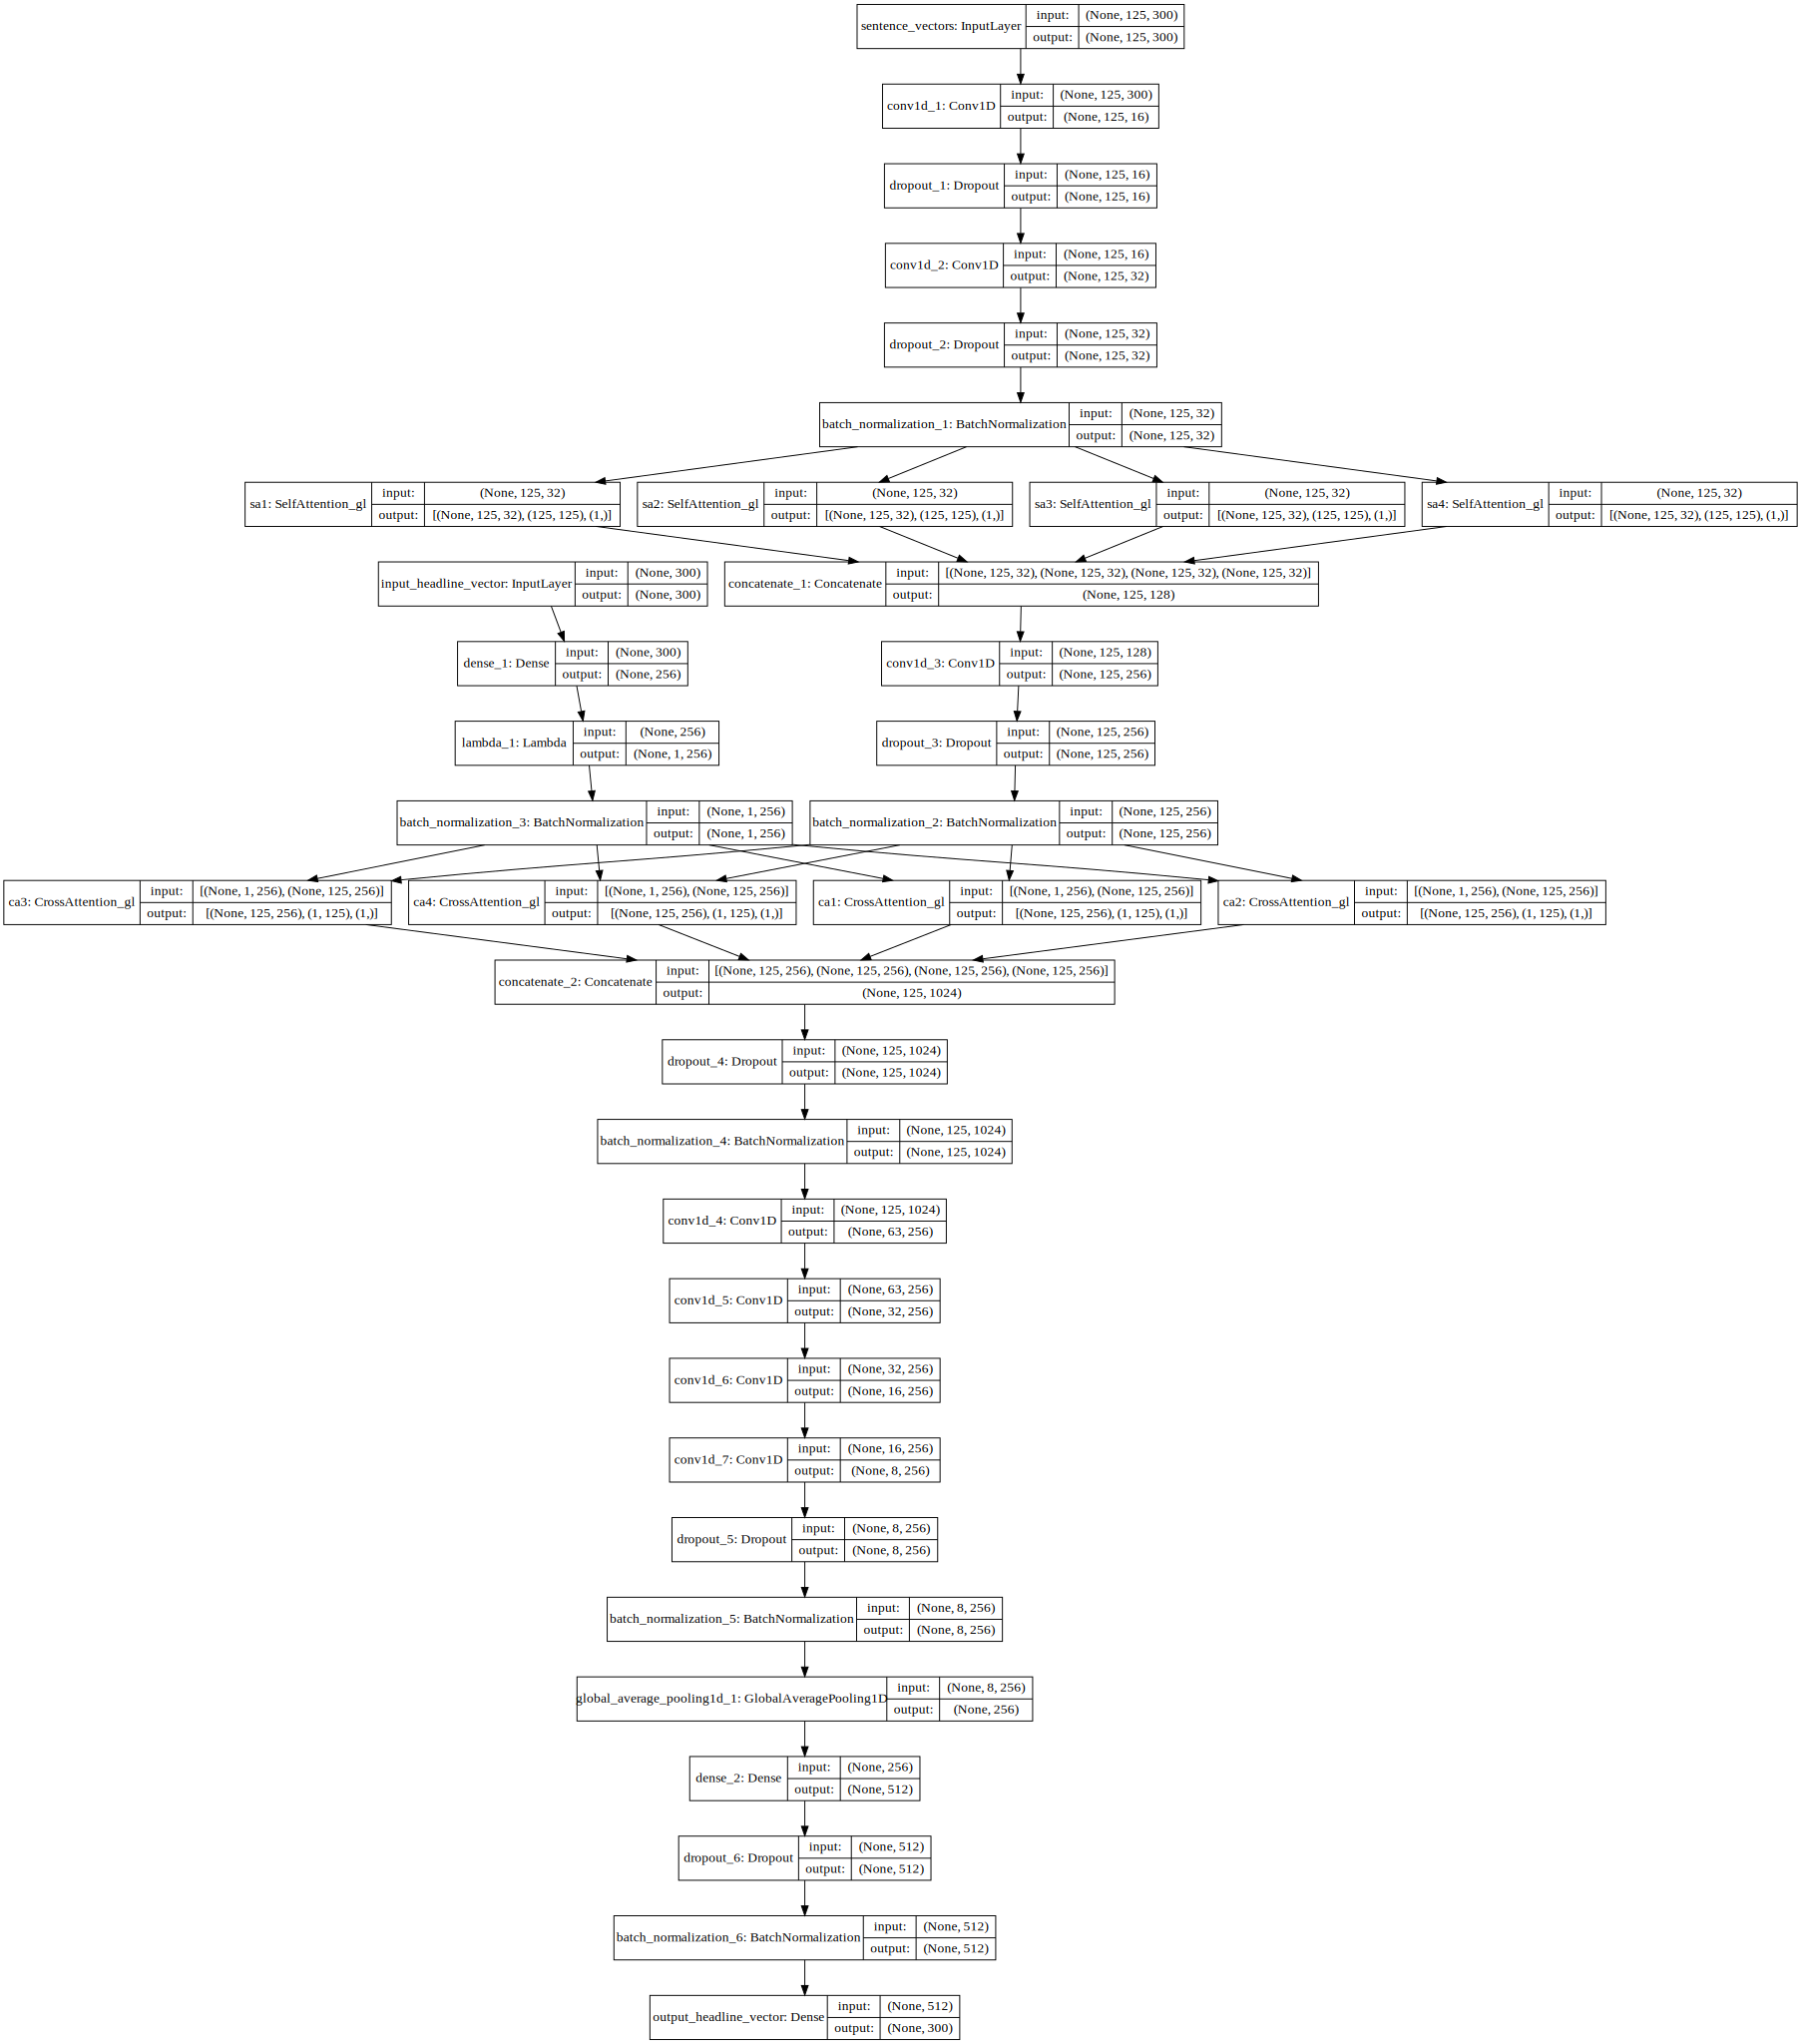

In [16]:
def build_model():
    inp_sentence_vectors = Input(shape=(max_sentences, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='input_headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu', padding='same')(conv1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = BatchNormalization()(conv2)
    sent_sa_feat_1, sent_beta_1, sent_gamma_1 = SelfAttention(int(conv2.shape[-1]), name = 'sa1')(conv2)
    sent_sa_feat_2, sent_beta_2, sent_gamma_2 = SelfAttention(int(conv2.shape[-1]), name = 'sa2')(conv2)
    sent_sa_feat_3, sent_beta_3, sent_gamma_3 = SelfAttention(int(conv2.shape[-1]), name = 'sa3')(conv2)
    sent_sa_feat_4, sent_beta_4, sent_gamma_4 = SelfAttention(int(conv2.shape[-1]), name = 'sa4')(conv2)
    concat1 = Concatenate()([sent_sa_feat_1,sent_sa_feat_2,sent_sa_feat_3,sent_sa_feat_4])
    conv3 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat1)
    conv3 = Dropout(0.5)(conv3)
    conv3 = BatchNormalization()(conv3)
    headline = Dense(256, activation='relu')(inp_headline_vector)
    headline = Lambda(lambda x:K.expand_dims(x, axis=1))(headline)
    headline = BatchNormalization()(headline)
    sent_hd_sa_feat_1, sent_hd_beta_1, sent_hd_gamma_1 = CrossAttention(int(conv3.shape[-1]), name = 'ca1')([headline,conv3])
    sent_hd_sa_feat_2, sent_hd_beta_2, sent_hd_gamma_2 = CrossAttention(int(conv3.shape[-1]), name = 'ca2')([headline,conv3])
    sent_hd_sa_feat_3, sent_hd_beta_3, sent_hd_gamma_3 = CrossAttention(int(conv3.shape[-1]), name = 'ca3')([headline,conv3])
    sent_hd_sa_feat_4, sent_hd_beta_4, sent_hd_gamma_4 = CrossAttention(int(conv3.shape[-1]), name = 'ca4')([headline,conv3])  
    concat3 = Concatenate()([sent_hd_sa_feat_1,sent_hd_sa_feat_2,sent_hd_sa_feat_3,sent_hd_sa_feat_4])
    concat3 = Dropout(0.5)(concat3)
    concat3 = BatchNormalization()(concat3)
    conv5 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(concat3)
    conv6 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv5)
    conv7 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv6)
    conv8 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv7)
    conv8 = Dropout(0.5)(conv8)
    conv8 = BatchNormalization()(conv8)
    gap = GlobalAveragePooling1D()(conv8)
#     repeat = RepeatVector(50)(gap)
#     lstm = LSTM(256,return_sequences=True)(repeat)
    dense1 = Dense(512,activation='relu')(gap)
    dense1 = Dropout(0.5)(dense1)
    dense1 = BatchNormalization()(dense1)
    gen_hd_vector = Dense(300,activation='linear', name='output_headline_vector')(dense1)
    model = Model([inp_sentence_vectors,inp_headline_vector],gen_hd_vector)
    return model
model = build_model()
model.compile(optimizer=optimizers.Adam(lr=0.0001,beta_1=0.0,beta_2=0.99),loss='mse')
model.summary()
# print('model params:',model.count_params())
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [17]:
dt = datetime.now()
mc = ModelCheckpoint('weights/dnf700_sa_sent_hd_vector_gl.hdf5',save_best_only=True,save_weights_only=True)
tb = TensorBoard(batch_size=32,log_dir='logs/dnf700_sa_sent_hd_vector_gl/{0}'.format(dt.timestamp()),write_graph=True)

In [ ]:
hist = model.fit_generator(tdg, callbacks=[mc,tb], initial_epoch=0
                           ,steps_per_epoch=train_steps_per_epoch
                           ,validation_data=vdg
                           ,validation_steps=val_steps_per_epoch
                           ,epochs=epochs)

Epoch 1/2000
4/4 [==============================] - 13s 3s/step - loss: 1.2581 - val_loss: 0.3333
Epoch 2/2000
4/4 [==============================] - 0s 64ms/step - loss: 1.2450 - val_loss: 0.3014
Epoch 3/2000
4/4 [==============================] - 0s 68ms/step - loss: 1.2100 - val_loss: 0.2690
Epoch 4/2000
4/4 [==============================] - 2s 397ms/step - loss: 1.2144 - val_loss: 0.2569
Epoch 5/2000
4/4 [==============================] - 2s 595ms/step - loss: 1.2041 - val_loss: 0.2481
Epoch 6/2000
4/4 [==============================] - 2s 616ms/step - loss: 1.2155 - val_loss: 0.2477
Epoch 7/2000
4/4 [==============================] - 3s 644ms/step - loss: 1.1901 - val_loss: 0.2299
Epoch 8/2000
4/4 [==============================] - 2s 536ms/step - loss: 1.1845 - val_loss: 0.2278
Epoch 9/2000
4/4 [==============================] - 3s 647ms/step - loss: 1.1791 - val_loss: 0.2191
Epoch 10/2000
4/4 [==============================] - 3s 633ms/step - loss: 1.1641 - val_loss: 0.2223
Epo

4/4 [==============================] - 3s 700ms/step - loss: 0.7203 - val_loss: 0.0570
Epoch 83/2000
4/4 [==============================] - 3s 716ms/step - loss: 0.7115 - val_loss: 0.0591
Epoch 84/2000
4/4 [==============================] - 3s 684ms/step - loss: 0.7060 - val_loss: 0.0567
Epoch 85/2000
4/4 [==============================] - 3s 699ms/step - loss: 0.6996 - val_loss: 0.0543
Epoch 86/2000
4/4 [==============================] - 3s 639ms/step - loss: 0.6774 - val_loss: 0.0569
Epoch 87/2000
4/4 [==============================] - 3s 764ms/step - loss: 0.6694 - val_loss: 0.0523
Epoch 88/2000
4/4 [==============================] - 2s 559ms/step - loss: 0.6744 - val_loss: 0.0528
Epoch 89/2000
4/4 [==============================] - 2s 532ms/step - loss: 0.6889 - val_loss: 0.0491
Epoch 90/2000
4/4 [==============================] - 2s 606ms/step - loss: 0.6839 - val_loss: 0.0506
Epoch 91/2000
4/4 [==============================] - 3s 708ms/step - loss: 0.6808 - val_loss: 0.0489
Epoc

4/4 [==============================] - 2s 572ms/step - loss: 0.4703 - val_loss: 0.0203
Epoch 163/2000
4/4 [==============================] - 2s 623ms/step - loss: 0.4659 - val_loss: 0.0215
Epoch 164/2000
4/4 [==============================] - 2s 611ms/step - loss: 0.4737 - val_loss: 0.0212
Epoch 165/2000
4/4 [==============================] - 3s 692ms/step - loss: 0.4600 - val_loss: 0.0218
Epoch 166/2000
4/4 [==============================] - 3s 648ms/step - loss: 0.4650 - val_loss: 0.0187
Epoch 167/2000
4/4 [==============================] - 2s 609ms/step - loss: 0.4705 - val_loss: 0.0210
Epoch 168/2000
4/4 [==============================] - 3s 732ms/step - loss: 0.4539 - val_loss: 0.0213
Epoch 169/2000
4/4 [==============================] - 3s 691ms/step - loss: 0.4487 - val_loss: 0.0206
Epoch 170/2000
4/4 [==============================] - 2s 624ms/step - loss: 0.4574 - val_loss: 0.0188
Epoch 171/2000
4/4 [==============================] - 2s 619ms/step - loss: 0.4502 - val_loss: 0.

In [ ]:
# from matplotlib import pyplot as plt
# acc = hist.history['acc']
# loss = hist.history['loss']

# # Create count of the number of epochs
# epoch_count = range(1, len(acc) + 1)

# # Visualize loss history
# # plt.plot(epoch_count, acc, 'b-')
# fig, ax = plt.subplots(ncols=2,sharex=True)
# ax[0].plot(epoch_count, loss, 'r--')
# ax[0].legend(['Loss'])
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')
# ax[1].plot(epoch_count, acc, 'b-')
# ax[1].legend(['Accuracy'])
# ax[1].set_xlabel('Epoch')
# ax[1].set_xlabel('Accuracy')
# plt.show();

In [ ]:
# df_res = pd.DataFrame(hist.history)

In [ ]:
# df_res[['loss','val_loss']].plot()

In [ ]:
# # df_res[['acc','val_acc']].plot()
# hd_nlp = nlp("What is you name my name is Anthony Gonsalves What is you name my name is Anthony GonsalvesWhat is you name my name is Anthony GonsalvesWhat is you name my name is Anthony GonsalvesWhat is you name my name is Anthony GonsalvesWhat is you name my name is Anthony Gonsalves!".lower())
# len(hd_nlp[:50])

# Evalutate SST

In [ ]:
model.load_weights('weights/dnf700_sa_sent_hd_vector_gl.hdf5')
model.evaluate_generator(test_dg,steps=5,pickle_safe = True)

In [ ]:
x,y = next(test_dg)
pred = model.predict(x)

In [ ]:
x['headline']

In [ ]:
test_idx = np.random.randint(0,50)
display(x['headline'][test_idx])

In [ ]:
x['sentences'][test_idx]

# Model Test

In [ ]:
model_1 = Model(model.inputs,model.get_layer(name='ca1').output)
model_2 = Model(model.inputs,model.get_layer(name='ca2').output)
model_3 = Model(model.inputs,model.get_layer(name='ca3').output)
model_4 = Model(model.inputs,model.get_layer(name='ca4').output)
model_1.summary()
model_2.summary()
model_3.summary()
model_4.summary()

In [ ]:

_, b1, g1 = model_1.predict(x)
_, b2, g2 = model_2.predict(x)
_, b3, g3 = model_3.predict(x)
_, b4, g4 = model_4.predict(x)

In [ ]:
b = b1+b2+b3+b4

In [ ]:
best_N = 5
t = b[test_idx][0][:len(x['sentences'][test_idx])].argsort()[-best_N:][::-1]
t

In [ ]:
print(len(x['sentences'][test_idx]))
b[test_idx][0][:len(x['sentences'][test_idx])].sum()

In [ ]:
display(x['headline'][test_idx])
display(x['claims'][test_idx])

In [ ]:
for s in t:
    if s>=len(x['sentences'][test_idx]):continue
    print(s,':',x['sentences'][test_idx][s])

In [ ]:
print(len(x['sentences'][test_idx]))
h_s_attended_vector = b[test_idx][0][:len(x['sentences'][test_idx])]
h_s_attended_vector.sum()

In [ ]:
df_h_s_attended_vector = pd.DataFrame(h_s_attended_vector)


xw = df_h_s_attended_vector.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
xw_scaled = min_max_scaler.fit_transform(xw)
df_h_s_attended_vector = pd.DataFrame(xw_scaled)

In [ ]:
sns.set(rc={'figure.figsize':(2.0,7.0)})
sns.heatmap(df_h_s_attended_vector, annot=True, cmap='YlGnBu', )

# Between Sentences

In [ ]:
model_s1 = Model(model.inputs,model.get_layer(name='sa1').output)
model_s2 = Model(model.inputs,model.get_layer(name='sa2').output)
model_s3 = Model(model.inputs,model.get_layer(name='sa3').output)
model_s4 = Model(model.inputs,model.get_layer(name='sa4').output)
model_s1.summary()
model_s2.summary()
model_s3.summary()
model_s4.summary()

In [ ]:
_, sb1, sg1 = model_s1.predict([x['sentence_vectors'],x['input_headline_vector']])
_, sb2, sg2 = model_s2.predict(x)
_, sb3, sg3 = model_s3.predict(x)
_, sb4, sg4 = model_s4.predict(x)

In [ ]:
sb = sb1[test_idx]#+sb2[test_idx]+sb3[test_idx]+sb4[test_idx]
sb = sb[:len(x['sentences'][test_idx]),:len(x['sentences'][test_idx])]

sb.shape

In [ ]:
df_sb = pd.DataFrame(sb)


# zx = df_sb.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# zx_scaled = min_max_scaler.fit_transform(zx)
# df_sb = pd.DataFrame(zx_scaled)

In [ ]:
sns.set(rc={'figure.figsize':(14.0,12.0)})
sns.heatmap(pd.DataFrame(df_sb),annot=True,cmap='YlGnBu')

In [ ]:
pd.DataFrame(x['sentences'][test_idx])